### Prepare data

In [90]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point, Polygon, shape, mapping, LineString, MultiLineString
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt
import mplleaflet
from geopandas import GeoDataFrame
import geopandas as gpd
from collections import Counter
import glob
from pygeoif import geometry
import libpysal

In [91]:
crs = {'init': 'epsg:4326'}
cea = {'proj':'cea'}
amersfoort = {'init': 'epsg:28992'}
mercator = {'init': '3395'}

In [92]:
pd.set_option("display.max_rows", 10000)
pd.set_option("display.max_columns", 100)

Import all data

In [93]:
df_buurt = pd.read_csv("Data/buurt.csv", sep=";", 
                       usecols=['OBJECTNUMMER', 'Buurt', 'Buurt_code', 'Buurtcombinatie_code', 'Opp_m2', 'WKT_LNG_LAT'])

In [94]:
df_grond = pd.read_csv("Data/grond.csv", sep=";", usecols=['AMScode_Oms', 'CBScode1_Oms',  'WKT_LNG_LAT'])
df_boom = pd.concat([pd.read_csv(file, dtype=str, sep=';', usecols=['Boomnummer', 'WKT_LNG_LAT']) for file in glob.glob('Data/boom*')], 
                    axis=0, ignore_index=True)
df_plan = pd.read_csv("Data/plan.csv", sep=";", usecols=['OBJECTNUMMER', 'WKT_LNG_LAT'])
df_strat = pd.read_csv("Data/strat.csv", sep=';', usecols=['OBJECTNUMMER', 'PROJECTNAAM', 'Fase', 'WKT_LNG_LAT'])

Set the coordinates for the GeoDataFrames. We make MultiPolygons instead of regular Polygons, because some of the rows contain MultiPolygons and ignoring them results in strange area display.

In [95]:
grond_geom = gpd.GeoSeries(df_grond.WKT_LNG_LAT.apply(wkt.loads).apply(lambda x: MultiPolygon([x])))
buurt_geom = gpd.GeoSeries(df_buurt.WKT_LNG_LAT.apply(wkt.loads).apply(lambda x: MultiPolygon([x])))
boom_geom = gpd.GeoSeries(df_boom.WKT_LNG_LAT.str.replace(",", " ").apply(wkt.loads))
plan_geom = gpd.GeoSeries(df_plan.WKT_LNG_LAT.apply(wkt.loads).apply(lambda x: MultiPolygon([x])))
strat_geom = gpd.GeoSeries(df_strat.WKT_LNG_LAT.apply(lambda x: geometry.from_wkt(x)).apply(lambda g: shape(g)))

In [96]:
gdf_grond = GeoDataFrame(df_grond, geometry=grond_geom).drop(['WKT_LNG_LAT'], axis=1)
gdf_buurt = GeoDataFrame(df_buurt, geometry=buurt_geom).drop(['WKT_LNG_LAT'], axis=1)
gdf_boom = GeoDataFrame(df_boom, geometry=boom_geom).drop(['WKT_LNG_LAT'], axis=1)
gdf_plan = GeoDataFrame(df_plan, geometry=plan_geom).drop(['WKT_LNG_LAT'], axis=1)
gdf_strat = GeoDataFrame(df_strat, geometry=strat_geom).drop(['WKT_LNG_LAT'], axis=1)

### Buurt

Include counter of amount of trees per area

In [97]:
df_temp = gpd.sjoin(gdf_buurt, gdf_boom, how='left', op='contains').groupby("Buurt").count().\
    Boomnummer.reset_index().\
    rename(columns={'index': 'Buurt'}).\
    rename(columns={'Boomnummer': 'aantal_bomen'})
gdf_buurt = gdf_buurt.merge(df_temp, on=["Buurt"])
del df_temp

Tree Index

In [98]:
gdf_buurt["aantal_bomen_m2"] = gdf_buurt.aantal_bomen / gdf_buurt.Opp_m2
gdf_buurt["aantal_bomen_index"] = gdf_buurt.aantal_bomen_m2 / gdf_buurt.aantal_bomen_m2.max() 

Define Amsterdam: All areas except for 'Stadsdeel N'

Amsterdam = gdf_buurt[gdf_buurt.Buurtcombinatie_code != 'N73'].geometry.unary_union

Amsterdam

### Terrains

Trees per terrain

df_temp = gpd.sjoin(gdf_grond, gdf_boom, how='left', op='contains').groupby("OBJECTNUMMER").count().\
    Boomtype.reset_index().\
    rename(columns={'index': 'OBJECTNUMMER'}).\
    rename(columns={'Boomtype': 'aantal_bomen'})
gdf_grond = gdf_grond.merge(df_temp, on=["OBJECTNUMMER"])
del df_temp

Tree Index

gdf_grond["aantal_bomen_m2"] = gdf_grond.aantal_bomen / gdf_grond.Oppervlakte_m2
gdf_grond["aantal_bomen_index"] = gdf_grond.aantal_bomen_m2 / gdf_grond.aantal_bomen_m2.max() 

Define terrains suitable for planting clusters of trees

terrains = ["Bouwterrein woonbestemming", "Bouwterrein niet-woon bestemming", 
            "Tijdelijke opslag van grond", "Semi-verhard overig terrein"]
terrein = list(gdf_grond.CBScode1_Oms.unique())

Select only those terrains that are within Amsterdam

gdf_grond["InBuurt"] = gdf_grond.geometry.apply(lambda x: True if Amsterdam.contains(x) else False)

gdf_temp = gdf_grond[gdf_grond.AMScode_Oms.isin(terrains)]
gdf_grond_in_buurt = gdf_temp[gdf_grond.InBuurt.isin([True])]
gdf_grond_in_buurt["aantal_bomen_index"] = gdf_grond_in_buurt.aantal_bomen_m2 / gdf_grond_in_buurt.aantal_bomen_m2.max()
del gdf_temp

### Housing plans

Trees per plan

In [99]:
df_temp = gpd.sjoin(gdf_strat, gdf_boom, how='left', op='contains').groupby("OBJECTNUMMER").count().\
    Boomnummer.reset_index().\
    rename(columns={'index': 'OBJECTNUMMER'}).\
    rename(columns={'Boomnummer': 'aantal_bomen'})
gdf_strat = gdf_strat.merge(df_temp, on=["OBJECTNUMMER"])
del df_temp

Tree Index

In [100]:
gdf_strat["area"] = gdf_strat.geometry.apply(lambda x: x.area)

In [101]:
gdf_strat["aantal_bomen_area"] = gdf_strat.aantal_bomen / gdf_strat.area
gdf_strat["aantal_bomen_index"] = gdf_strat.aantal_bomen_area / gdf_strat.area.max() 

gdf_strat["InBuurt"] = gdf_strat.geometry.apply(lambda x: True if Amsterdam.contains(x) else False)

gdf_strat_in_buurt = gdf_strat[gdf_strat.InBuurt.isin([True])]

In [102]:
gdf_temp = gpd.overlay(GeoDataFrame(df_buurt, geometry=buurt_geom), 
                                 GeoDataFrame(df_strat, geometry=strat_geom), 
                                 how='intersection').drop(['OBJECTNUMMER_1', 'OBJECTNUMMER_2',
                                                          'WKT_LNG_LAT_1', 'WKT_LNG_LAT_2'], axis=1).reset_index().\
    rename(columns={"index": "Id"})
# .\
#     drop(['OBJECTNUMMER_2', 'OBJECTNUMMER_1'], axis=1).reset_index().\ #.rename(columns={"OBJECTNUMMER_1": "OBJECTNUMMER"}).reset_index().\
#     rename(columns={"index": "Id"})

In [103]:
df_temp = gpd.sjoin(gdf_temp, gdf_boom, how='left', op='contains').groupby("Id").count().\
    Boomnummer.reset_index().\
    rename(columns={'Boomnummer': 'aantal_bomen'})

In [104]:
gdf_strat_in_buurt = gdf_temp.merge(df_temp, on=["Id"]).drop(['Id'], axis=1)
del df_temp, gdf_temp

In [105]:
gdf_strat_in_buurt["area"] = gdf_strat_in_buurt.geometry.apply(lambda x: x.area)
gdf_strat_in_buurt["aantal_bomen_area"] = gdf_strat_in_buurt.aantal_bomen / gdf_strat_in_buurt.area
gdf_strat_in_buurt["aantal_bomen_index"] = gdf_strat_in_buurt.aantal_bomen_area / gdf_strat_in_buurt.area.max() 

### Visualisation

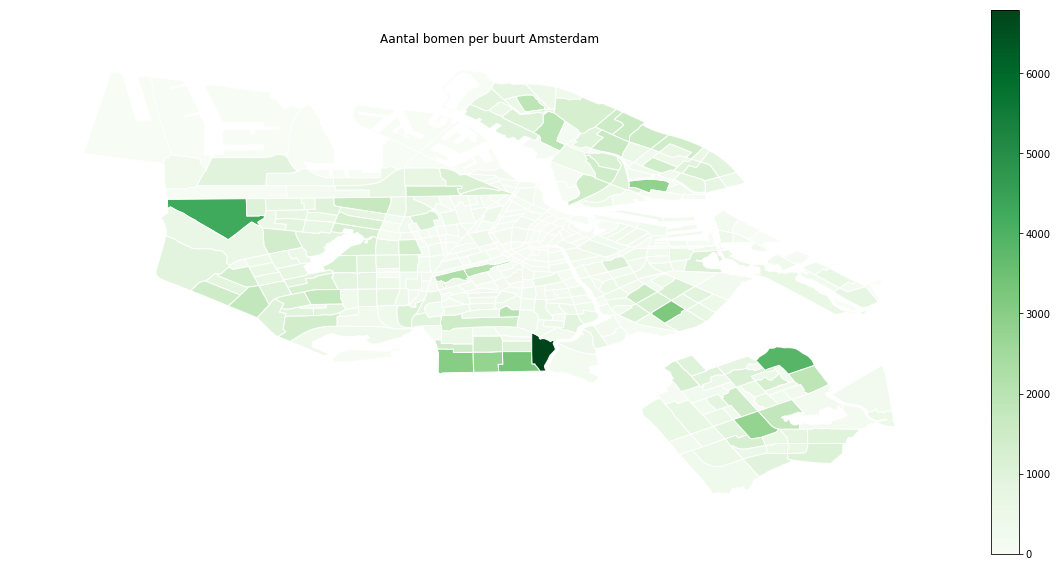

In [150]:
fig, ax = plt.subplots(1, figsize=(20, 10))
plt.title("Aantal bomen per buurt Amsterdam")
gdf_buurt[gdf_buurt.Buurtcombinatie_code != 'N73'].plot(ax=ax, column= 'aantal_bomen', 
                                                        cmap='Greens', edgecolor='white', facecolor='black')
ax.axis('off')
vmin = gdf_buurt['aantal_bomen'].min()
vmax = gdf_buurt['aantal_bomen'].max()
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
plt.show();

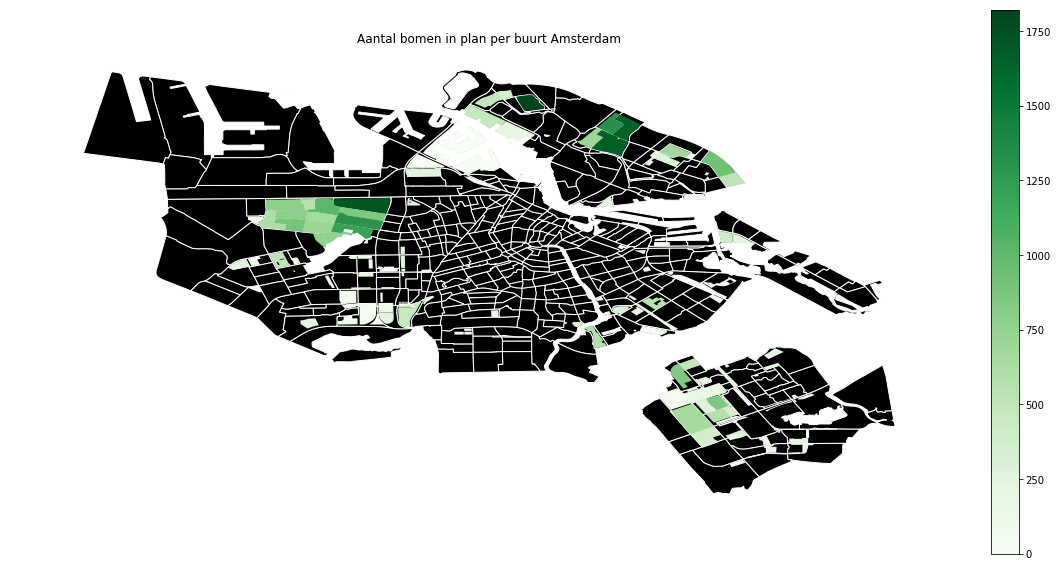

In [149]:
fig, ax = plt.subplots(1, figsize=(20, 10))
plt.title("Aantal bomen in plan per buurt Amsterdam")
gdf_buurt[gdf_buurt.Buurtcombinatie_code != 'N73'].plot(ax=ax, edgecolor='white', facecolor='black')
gdf_strat_in_buurt.plot(ax=ax, column='aantal_bomen', cmap='Greens', alpha=1)
ax.axis('off')
vmin = gdf_strat_in_buurt['aantal_bomen'].min()
vmax = gdf_strat_in_buurt['aantal_bomen'].max()
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
plt.show();